In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import json

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


In [2]:
class MultiQueryAttention(nn.Module):
    """
    Multi-query attention: multiple queries, but shared key and value.

    """

    def __init__(self, dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5 #scales down attention scores so gradient remains stables 

        self.q_proj = nn.Linear(dim, dim) 

        self.k_proj = nn.Linear(dim, self.head_dim)
        self.v_proj = nn.Linear(dim, self.head_dim)

        self.proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape

        q = self.q_proj(x).reshape(B, N, self.num_heads, self.head_dim)
        q = q.permute(0, 2, 1, 3)

        k = self.k_proj(x) #shared K & V for all heads
        v = self.v_proj(x)

        k = k.unsqueeze(1)
        v = v.unsqueeze(1)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        x = (attn @ v)
        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)

        return x 

print("Testing Multi-query Attention...")
mqa = MultiQueryAttention(dim=64, num_heads=4)
test_input = torch.randn(2, 16, 64)
test_output = mqa(test_input)

print(f"✔️ Input shape: {test_input.shape}")
print(f"✔️ Output shape: {test_output.shape}")

mqa_params = sum(p.numel() for p in mqa.parameters()) #counts every weight in the model
print(f"✔️ Multi - Query Attention parameters: {mqa_params:,}")

Testing Multi-query Attention...
✔️ Input shape: torch.Size([2, 16, 64])
✔️ Output shape: torch.Size([2, 16, 64])
✔️ Multi - Query Attention parameters: 10,400


In [3]:
from torchvision import datasets, transforms

class StandardAttention(nn.Module):
    def __init__(self, dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

std_attn = StandardAttention(dim=64, num_heads=4)
mq_attn = MultiQueryAttention(dim=64, num_heads=4)

std_params = sum(p.numel() for p in std_attn.parameters())
mq_params = sum(p.numel() for p in mq_attn.parameters())

print("\n" + "="*60)
print("PARAMETER COMPARISON")
print("="*60)
print(f"Standard Attention: {std_params:,} parameters")
print(f"Multi-Query Attention: {mq_params:,} paramters")
print(f"Reduction:              {std_params - mq_params:,} parameters ({(1 - mq_params/std_params)*100:.1f}% fewer)")
print("="*60)


PARAMETER COMPARISON
Standard Attention: 16,640 parameters
Multi-Query Attention: 10,400 paramters
Reduction:              6,240 parameters (37.5% fewer)


In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=2, embed_dim=64):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class TransformerBlock(nn.Module):
    """Transformer block - now using Multi-Query Attention!"""
    def __init__(self, dim, num_heads=4, mlp_ratio=4, dropout=0.1, use_mqa=True):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        
        # Choose attention type
        if use_mqa:
            self.attn = MultiQueryAttention(dim, num_heads, dropout)
        else:
            self.attn = StandardAttention(dim, num_heads, dropout)
            
        self.norm2 = nn.LayerNorm(dim)
        
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

print("✓ Building blocks defined!")

✓ Building blocks defined!


In [5]:
class VisionTransformerTracker(nn.Module):
    """ Vision transformer for tracking - with Multi-Query Attention """
    def __init__(
        self,
        img_size=32,
        patch_size=4,
        in_channels=2,
        embed_dim=64,
        depth=4,
        num_heads=4,
        mlp_ratio=4,
        dropout=0.1,
        use_mqa=True
    ):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.dropout = nn.Dropout(dropout)

        #Transformer blocks with Multi-Query attention
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout, use_mqa=use_mqa)
            for _ in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)

        self.head = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.GELU(),
            nn.Linear(embed_dim // 2, 2)
        )

    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)
        pos = self.head(x)

        return pos

print("Creating Multi-Query Attention model...")
mq_model = VisionTransformerTracker(
    img_size=32,
    patch_size=4,
    embed_dim=64,
    depth=4,
    num_heads=4,
    use_mqa=True
).to(device)

mq_params = sum(p.numel() for p in mq_model.parameters())
print(f"✔️ Multi-Query model: {mq_params:,} parameters")

test_input = torch.randn(4, 2, 32, 32).to(device)
test_output = mq_model(test_input)
print(f"✔️ Output shape: {test_output.shape}")


Creating Multi-Query Attention model...
✔️ Multi-Query model: 183,458 parameters
✔️ Output shape: torch.Size([4, 2])


In [6]:
print("Loading dataset...")
data = np.load('../data/synthetic_tracking_dataset.npz', allow_pickle=True)
videos = data['videos']
positions = data['positions']

from torch.utils.data import Dataset

class TrackingDataset(Dataset):
    def __init__(self, videos, positions):
        self.videos = videos
        self.positions = positions

    def __len__(self):
        return len(self.videos) * (self.videos.shape[1] - 1)

    def __getitem__(self, idx):
        video_idx = idx // (self.videos.shape[1] - 1)
        frame_idx = idx % (self.videos.shape[1] - 1)

        frame1 = self.videos[video_idx, frame_idx]
        frame2 = self.videos[video_idx, frame_idx + 1]
        input_frames = np.stack([frame1, frame2], axis=0)
        target_pos = np.array(self.positions[video_idx][frame_idx + 1])

        return torch.FloatTensor(input_frames), torch.FloatTensor(target_pos)

full_dataset = TrackingDataset(videos, positions)
train_size = int(0.8 *  len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"✔️ Training samples: {len(train_dataset)}")
print(f"✔️ Validation samples: {len(val_dataset)}")

Loading dataset...
✔️ Training samples: 39200
✔️ Validation samples: 9800


In [7]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for inputs, targets in tqdm(dataloader, desc="Training"):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

    return total_loss / len(dataloader)

print("✔️ Training functions ready!")

✔️ Training functions ready!


Training Multi-Query Attention model...


Training: 100%|█████████████████████████████| 1225/1225 [00:39<00:00, 31.29it/s]


Epoch 1/20
 Train Loss: 44.1065
 Val Loss: 21.0341
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:40<00:00, 30.10it/s]


Epoch 2/20
 Train Loss: 4.2129
 Val Loss: 0.8672
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:40<00:00, 30.46it/s]


Epoch 3/20
 Train Loss: 1.1383
 Val Loss: 0.5195
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:41<00:00, 29.76it/s]


Epoch 4/20
 Train Loss: 0.6534
 Val Loss: 0.3910
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:39<00:00, 30.64it/s]


Epoch 5/20
 Train Loss: 0.4726
 Val Loss: 0.1846
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:39<00:00, 31.04it/s]


Epoch 6/20
 Train Loss: 0.3609
 Val Loss: 0.2692
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:39<00:00, 31.39it/s]


Epoch 7/20
 Train Loss: 0.3076
 Val Loss: 0.2025
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:38<00:00, 31.46it/s]


Epoch 8/20
 Train Loss: 0.2415
 Val Loss: 0.1270
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:40<00:00, 30.40it/s]


Epoch 9/20
 Train Loss: 0.2053
 Val Loss: 0.0832
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:39<00:00, 31.16it/s]


Epoch 10/20
 Train Loss: 0.1762
 Val Loss: 0.0731
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:38<00:00, 31.42it/s]


Epoch 11/20
 Train Loss: 0.1542
 Val Loss: 0.0596
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:39<00:00, 30.94it/s]


Epoch 12/20
 Train Loss: 0.1326
 Val Loss: 0.0887
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:38<00:00, 31.93it/s]


Epoch 13/20
 Train Loss: 0.1192
 Val Loss: 0.0574
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:38<00:00, 32.01it/s]


Epoch 14/20
 Train Loss: 0.1071
 Val Loss: 0.0527
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:38<00:00, 32.09it/s]


Epoch 15/20
 Train Loss: 0.0973
 Val Loss: 0.0521
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:38<00:00, 32.04it/s]


Epoch 16/20
 Train Loss: 0.0902
 Val Loss: 0.0363
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:38<00:00, 32.07it/s]


Epoch 17/20
 Train Loss: 0.0844
 Val Loss: 0.0371
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:38<00:00, 32.02it/s]


Epoch 18/20
 Train Loss: 0.0805
 Val Loss: 0.0418
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:38<00:00, 32.13it/s]


Epoch 19/20
 Train Loss: 0.0774
 Val Loss: 0.0401
------------------------------------------------------------


Training: 100%|█████████████████████████████| 1225/1225 [00:38<00:00, 32.06it/s]


Epoch 20/20
 Train Loss: 0.0751
 Val Loss: 0.0380
------------------------------------------------------------

✔️ Training completed!


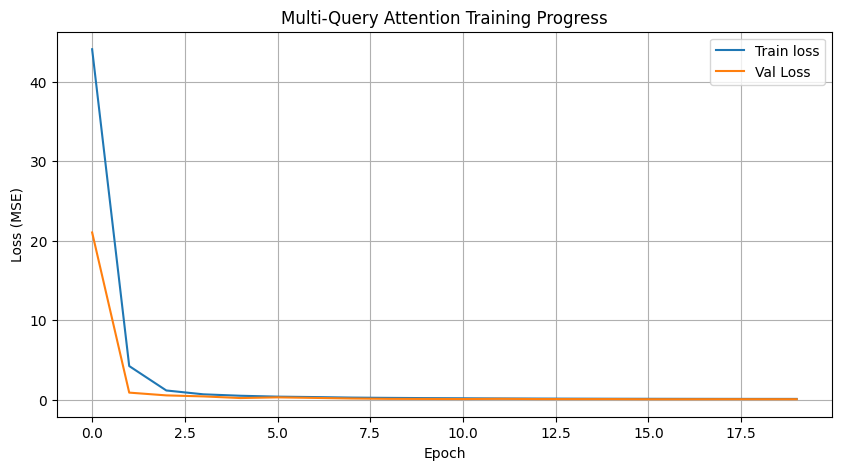

In [8]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(mq_model.parameters(), lr=0.001, weight_decay=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

num_epochs = 20
train_losses = []
val_losses = []

print("Training Multi-Query Attention model...")
print("="*60)

for epoch in range(num_epochs):
    train_loss = train_epoch(mq_model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    val_loss = validate(mq_model, val_loader, criterion, device)
    val_losses.append(val_loss)

    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f" Train Loss: {train_loss:.4f}")
    print(f" Val Loss: {val_loss:.4f}")
    print("-"*60)
print("\n✔️ Training completed!")

#plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Multi-Query Attention Training Progress')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
def calculate_accuracy(model, dataloader, device, threshold=2.0):
    model.eval()
    total_error = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)

            distances = torch.sqrt(((outputs - targets) ** 2).sum(dim=1))
            total_error += distances.sum().item()
            correct += (distances < threshold).sum().item()
            total += len(distances)

    avg_error = total_error / total
    accuracy = (correct / total) * 100
    return avg_error, accuracy

print("Calculation Multi-Query accuracy...")
mq_avg_error, mq_accuracy = calculate_accuracy(mq_model, val_loader, device)

print(f"\n✔️ Average Position Error: {mq_avg_error:.2f} pixels")
print(f"✔️ Accuracy (within 2 pixels): {mq_accuracy:.2f}%")

Calculation Multi-Query accuracy...

✔️ Average Position Error: 0.24 pixels
✔️ Accuracy (within 2 pixels): 100.00%


In [11]:
def measure_fps(model, device, img_size=32, num_iterations=100):
    model.eval()
    dummy_input = torch.randn(1, 2, img_size, img_size).to(device)

    with torch.no_grad(): #warmup
        for _ in range(10):
            _ = model(dummy_input)

    if device.type == 'cuda':
        torch.cuda.synchhronize()

    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(dummy_input)

    if device.type == 'cuda':
        torch.cuda.synchronize()

    end_time = time.time()
    total_time = end_time - start_time
    fps = num_iterations / total_time
    latency = (total_time / num_iterations) * 1000

    return fps, latency

print("Measuring Multi_Query inference speed...")
mq_fps, mq_latency = measure_fps(mq_model, device)

print(f"\n✔️ FPS: {mq_fps:.2f} frames/second")
print(f"✔️ Latency: {mq_latency:.2f} ms/frame") #better latency, means better performance of T-sphere

Measuring Multi_Query inference speed...

✔️ FPS: 1224.44 frames/second
✔️ Latency: 0.82 ms/frame


In [17]:
with open('../results/baseline_results.json', 'r') as f:
    baseline_results = json.load(f)

print("\n" + "="*70)
print(" "*20 + "COMPARISON RESULTS")
print("="*70)
print(f"{'Metric':<30} {'Standard':<20} {'Multi_query':<20}")
print("-"*70)
print(f"{'Parameters':<30} {baseline_results['num_parameters']:>15,} {mq_params:>15,}")
print(f"{'Avg Error (pixels)': <30} {baseline_results['avg_error_pixels']:>15.2f} {mq_avg_error:>15.2f}")
print(f"{'Accuracy (%)':<30} {baseline_results['accuracy_percent']:>15.2f} {mq_accuracy:>15.2f}")
print(f"{'FPS':<30} {baseline_results['fps']:>15.2f} {mq_fps:>15.2f}")
print(f"{'Latency (ms)':<30} {baseline_results['latency_ms']:>15.2f} {mq_latency:>15.2f}")
print("="*70)

param_reduction = (1 - mq_params/baseline_results['num_parameters']) * 100
fps_improvement = ((mq_fps - baseline_results['fps']) / baseline_results['fps']) * 100
accuracy_change = mq_accuracy - baseline_results['accuracy_percent']

print(f"\nParameter Reduction: {param_reduction:.1f}%")
print(f"Speed Improvement: {fps_improvement:+.1f}%")
print(f" Accuracy Change: {accuracy_change:+.2f}%")
print("="*70)


                    COMPARISON RESULTS
Metric                         Standard             Multi_query         
----------------------------------------------------------------------
Parameters                             208,418         183,458
Avg Error (pixels)                        0.13            0.24
Accuracy (%)                            100.00          100.00
FPS                                    1375.15         1224.44
Latency (ms)                              0.73            0.82

Parameter Reduction: 12.0%
Speed Improvement: -11.0%
 Accuracy Change: +0.00%


In [19]:
torch.save(mq_model.state_dict(), '../results/multiquery_model.pth')

mq_results = {
    'model': 'Multi-Query Vision Transformer',
    'avg_error_pixels': mq_avg_error,
    'accuracy_percejt': mq_accuracy,
    'fps': mq_fps,
    'latency_ms': mq_latency,
    'num_parameters':mq_params,
    'train_loss_final': train_losses[-1],
    'val_loss_final': val_losses[-1]
}

with open('../results/multiquery_results.json', 'w') as f:
    json.dump(mq_results, f, indent=4)

print("✔️ Multi-Query model saved!")
print("✔️ Results saved!")


✔️ Multi-Query model saved!
✔️ Results saved!
